In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
warnings.filterwarnings("ignore")
import datetime as datetime
import io
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', -1)

## 1. Data Ingestion

In [2]:
data=pd.read_csv('export interview data.csv')
fields = ['indd','label2']
label = pd.read_csv('label.csv', usecols=fields)

In [3]:
data.label.nunique()

23

## 2. Mapping labels to the respective Texts

- Note: export interview data, label 11 is missing

In [4]:
dic=label.set_index('indd')['label2'].to_dict()
data['label_text']=data.label.map(dic)
# for key, value in dic.items():
#     print(key,value)
print(dic)

{24: 'bank_charges', 1: 'transfer', 2: 'online_transactions', 3: 'vat', 4: 'phone_and_internet', 5: 'atm_withdrawal', 6: 'offline_transactions', 7: 'stamp_duties_charges', 8: 'atm_withdrawal_charges', 9: 'bills_or_fees', 10: 'reversals', 11: 'self_care', 12: 'miscellaneous', 13: 'food', 14: 'mature_loan_instalment', 15: 'others', 16: 'loan_repayment', 17: 'transportation', 18: 'investment', 19: 'salary', 20: 'cash_deposit', 21: 'health', 22: 'card_request_commission', 23: 'Rent'}


In [5]:
data.label_text.nunique()

23

#### Amount of Samples Label

<AxesSubplot:xlabel='count', ylabel='label_text'>

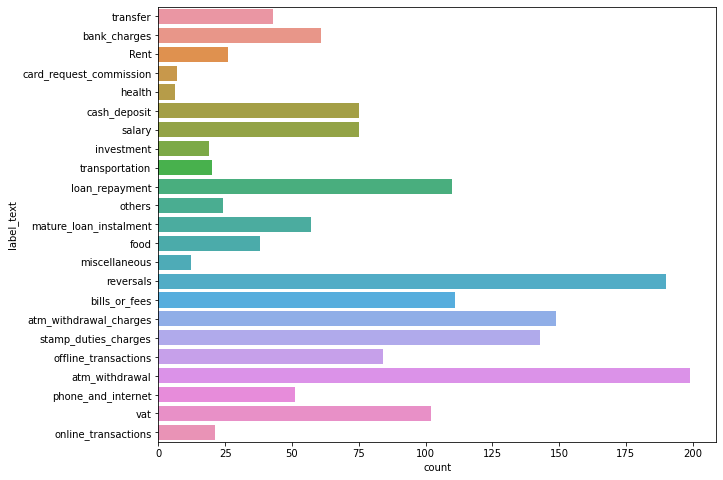

In [6]:
display(Markdown('#### Amount of Samples Label'))
plt.figure(figsize = (10, 8))
sns.countplot(data = data, y = 'label_text')

# 3.Data Cleaning

In [7]:
nltk.download('stopwords')
stop_words = stopwords.words('english')


new_stopwords = ["xx", "xxxx","via","gw","flw","f","onb", "pg", "nig", "i", 
                   "ac", "kla", "ik", "bw", "ly", "eg","kd","est", "enzy", "eomo", "epo", 
                 "erelesusi", "frozen", "err", "error", "ese", "ernest","buhari","love",
                'failure', "failed", "ezzy", "ezinna", "ezeugbor", "ezeokeke", "express", "expre", "exceeded", 
                 "fagbule"
]

stop_words.extend(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/favour.oyelami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# removing stopwords from short_messages

def clean_text(text):
    
    text = text.lower()
    text = re.sub("[0-9]", " ", text)
    text = re.sub("[^a-z -]", " ", text)
    
    result = [i for i in text.split() if i not in stop_words]
    result = ' '.join(result)
    
    return result


print('example of text before cleaning:       ', data['narrations'][5])
print('\n')

data['narrations'] = data['narrations'].apply(lambda x: clean_text(x))
print('example of text after cleaning:       ', data['narrations'][5])

example of text before cleaning:        NIBSS Instant Payment Outward via GTWORLD TO WEMA/buhari  love /./REF:GW f


example of text after cleaning:        nibss instant payment outward gtworld wema ref


In [9]:
data.head(4)

,narrations,label,label_text
0,nibss instant payment outward gtworld wema john doe tomiwa ref,1,transfer
1,commission nip transfer commission gtworld fcmb huddle stone ref,1,transfer
2,nibss instant payment nip reversal beneficiary bank ref,1,transfer
3,pos web purchase transaction -- --barter interswitchdelang,1,transfer


In [10]:
data['label'] = data['label_text'].factorize()[0]
mp_val = data[['label_text', 'label']].drop_duplicates().sort_values('label')
mp_val.reset_index(drop = True)

,label_text,label
0,transfer,0
1,bank_charges,1
2,Rent,2
3,card_request_commission,3
4,health,4
5,cash_deposit,5
6,salary,6
7,investment,7
8,transportation,8
9,loan_repayment,9


In [11]:
label_to_id = dict(mp_val.values)
id_to_label = dict(mp_val[['label', 'label_text']].values)
target_vals = list(id_to_label.values())
label_to_id

{'transfer': 0,
 'bank_charges': 1,
 'Rent': 2,
 'card_request_commission': 3,
 'health': 4,
 'cash_deposit': 5,
 'salary': 6,
 'investment': 7,
 'transportation': 8,
 'loan_repayment': 9,
 'others': 10,
 'mature_loan_instalment': 11,
 'food': 12,
 'miscellaneous': 13,
 'reversals': 14,
 'bills_or_fees': 15,
 'atm_withdrawal_charges': 16,
 'stamp_duties_charges': 17,
 'offline_transactions': 18,
 'atm_withdrawal': 19,
 'phone_and_internet': 20,
 'vat': 21,
 'online_transactions': 22}

## 4. Identifying Correlated keywords

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 2), stop_words=stop_words, lowercase = False)

features = tfidf.fit_transform(data['narrations']).toarray()
labels = data['label']

In [13]:
from sklearn.feature_selection import chi2
    
def get_most_corr_grams(trans_feats = features, target_col = 'column_name', N = 10, col_id_dict = 'column_name'):
    
    for i in target_col.unique():
        target_col_id = col_id_dict.get(i)
        
        features_chi2 = chi2(trans_feats, labels == target_col_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        
        print("n==> %s:" %(i))
        print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
        print()
        print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
        print('\n')
        
get_most_corr_grams(trans_feats = features, target_col = data['label_text'], N = 10, col_id_dict = label_to_id)
        
        
        
        
        


n==> transfer:
  * Most Correlated Unigrams are: afeez, adew, stone, window, paystack, wema, managed, virtual, id, slam

  * Most Correlated Bigrams are: managed acct, paystack virtual, paystack ref, virtual managed, id www, transfer uzikwendu, commission gtworld, commission nip, gtworld ref, gtworld wema


n==> bank_charges:
  * Most Correlated Unigrams are: withdrawal, atm, nibss, charge, current, maintenance, apr, sms, charges, alert

  * Most Correlated Bigrams are: nibss doe, charges talle, nibss john, charges sunday, charges john, nibss lily, charges bukola, alert charge, sms alert, alert charges


n==> Rent:
  * Most Correlated Unigrams are: olaleye, meriam, houserent, alli, metta, ceondotcom, olajide, adebote, house, rent

  * Most Correlated Bigrams are: kehinde babajide, ceondotcom company, mbanking part, olajide oluremi, emmanuella olajide, outward rent, part rent, gtworld house, rent ref, house rent


n==> card_request_commission:
  * Most Correlated Unigrams are: lily, acc

## 5. Split data into train and Test Set

In [14]:
x=data['narrations']
y=data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.2, random_state=42)

x_train_trans = tfidf.fit_transform(x_train)
x_test_trans = tfidf.transform(x_test)

## 6. Model Building

In [15]:
mnb_clf = MultinomialNB()
svc_clf = LinearSVC(random_state = 3)

###  6.1 Selecting Basline model

#### MultinomialNB based model

                         precision    recall  f1-score   support

               transfer       1.00      0.09      0.17        11
           bank_charges       0.80      0.73      0.76        11
                   Rent       0.00      0.00      0.00         6
card_request_commission       0.00      0.00      0.00         1
                 health       0.00      0.00      0.00         1
           cash_deposit       1.00      0.79      0.88        14
                 salary       1.00      0.50      0.67        18
             investment       0.00      0.00      0.00         6
         transportation       0.00      0.00      0.00         3
         loan_repayment       0.70      0.70      0.70        30
                 others       0.00      0.00      0.00         4
 mature_loan_instalment       0.80      0.40      0.53        10
                   food       0.00      0.00      0.00        12
          miscellaneous       0.00      0.00      0.00         3
              reversals 

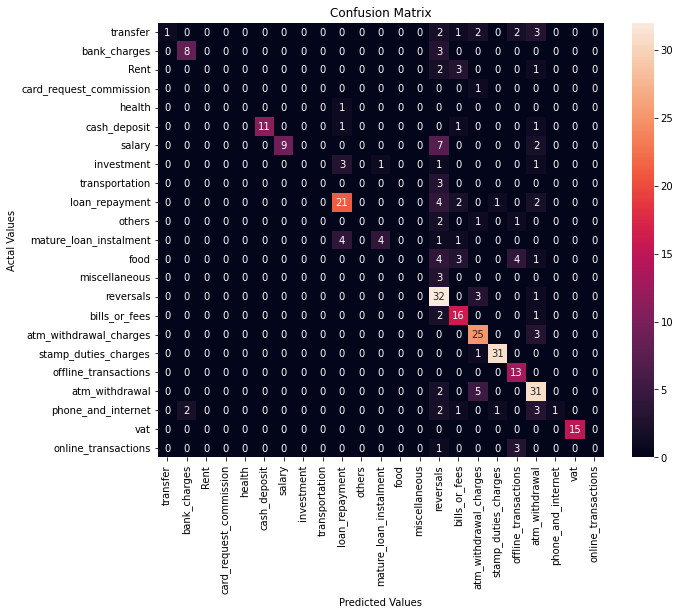

#### LinearSVC based model

                         precision    recall  f1-score   support

               transfer       1.00      0.82      0.90        11
           bank_charges       0.79      1.00      0.88        11
                   Rent       1.00      1.00      1.00         6
card_request_commission       1.00      1.00      1.00         1
                 health       0.00      0.00      0.00         1
           cash_deposit       1.00      0.86      0.92        14
                 salary       1.00      0.94      0.97        18
             investment       0.75      0.50      0.60         6
         transportation       1.00      1.00      1.00         3
         loan_repayment       0.84      0.90      0.87        30
                 others       0.00      0.00      0.00         4
 mature_loan_instalment       0.47      0.70      0.56        10
                   food       1.00      0.67      0.80        12
          miscellaneous       1.00      0.67      0.80         3
              reversals 

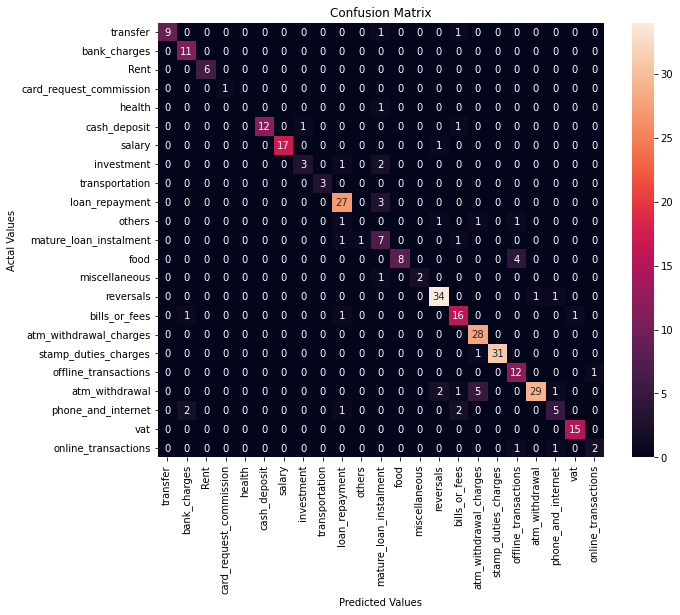

In [16]:
## Selecting Baslien model

def evaluate_model(model, x_train, x_test, y_train, y_test, y_pred):
    
    print('training_score:', model.score(x_train, y_train))
    print('testing_score:', model.score(x_test, y_test))
    print('difference between train and test score:', model.score(x_train, y_train) - model.score(x_test, y_test))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index = target_vals, columns = target_vals)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    

# benchmarking models and deriving metrics 
def benchmark_models(x_train, x_test, y_train, y_test, algs = [mnb_clf, svc_clf], target_names = target_vals):
    
    for alg in algs:
        algorithm_name = alg.__class__.__name__
        display(Markdown('#### {} based model'.format(algorithm_name)))
        
        alg.fit(x_train, y_train)
        y_pred = alg.predict(x_test)
        
        print(classification_report(y_test, y_pred, target_names = target_names))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index = target_vals, columns = target_vals)
    
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix_df, annot=True, fmt='g', )
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.xticks(rotation = 90)
        plt.show()
        
    
benchmark_models(x_train_trans, x_test_trans, y_train, y_test, algs = [mnb_clf, svc_clf], 
                 target_names = target_vals)


### 6.2 Selecting Linear Svc and the basline model

In [17]:
x=data['narrations']
y=data['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=3)


y_train_trans = y_train.map(id_to_label)
y_test_trans = y_test.map(id_to_label)


tfidf = TfidfVectorizer(encoding='latin-1',
                                min_df=2,
                                ngram_range=(1, 2), 
                                stop_words= stop_words, 
                                sublinear_tf=True)



# creating pipeline for prediction
svm_pipeline = Pipeline(steps = [('vectorizer', tfidf),
                                 ('make_predictions', svc_clf)])

svm_pipeline.fit(x_train, y_train_trans)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 sublinear_tf=True)),
                ('make_predictions', LinearSVC(random_state=3))])

In [18]:
# making predictions with pipeline object 
y_pred = svm_pipeline.predict(x_test)
print(classification_report(y_test_trans, y_pred, target_names = target_vals))

                         precision    recall  f1-score   support

               transfer       1.00      1.00      1.00         3
           bank_charges       0.95      0.90      0.92        40
                   Rent       0.91      1.00      0.95        31
card_request_commission       0.75      0.92      0.83        13
                 health       0.95      1.00      0.97        19
           cash_deposit       1.00      1.00      1.00         1
                 salary       0.88      0.96      0.92        23
             investment       1.00      1.00      1.00         3
         transportation       0.00      0.00      0.00         2
         loan_repayment       0.00      0.00      0.00         3
                 others       0.70      0.64      0.67        22
 mature_loan_instalment       0.55      0.46      0.50        13
                   food       0.67      0.67      0.67         3
          miscellaneous       0.80      0.94      0.86        17
              reversals 

In [19]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

In [20]:
print ('Accuracy:', accuracy_score(y_test_trans, y_pred))
print ('F1 score:', f1_score(y_test_trans, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test_trans, y_pred,
                              average='weighted'))

Accuracy: 0.8707692307692307
F1 score: 0.8643815681045892
Recall: 0.8707692307692307


## 7.0 Export Artifacts

In [21]:
import pickle

def export_object(filename = "filename", object_to_export = stop_words):
    
    dump_file = open(filename, "wb")
    pickle.dump(object_to_export, dump_file)
    dump_file.close()

In [22]:
## Model Pipeline
export_object(filename = "svm_model", object_to_export = svm_pipeline)

In [23]:
export_object(filename = "label_id_dictionary", object_to_export = label_id)

In [24]:
export_object(filename = "Text_Stopwords", object_to_export = stop_words)